In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error, r2_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, accuracy_score, classification_report, silhouette_score
from sklearn.model_selection import learning_curve, train_test_split
from scipy.stats import normaltest
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans, AgglomerativeClustering
from pandas.plotting import parallel_coordinates
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import pandas_ta as ta
import xgboost as xgb
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel
from fredapi import Fred
# %matplotlib inline

In [ ]:
#Run to get interactive plots
%matplotlib notebook

In [3]:
#Setup my Fred API
fred = Fred(api_key="15a7c21c16a08c2328d8afe299313b9d")

In [4]:
# Download stock data
df = yf.download("MSFT", start="2015-01-01", end="2020-01-01", auto_adjust=False)
sp500 = yf.download('^GSPC', start='2015-01-01', end='2020-01-01', auto_adjust=False)
# Calculate technical indicators using 'ta' package
df['Return'] = df['Adj Close'].pct_change()
# df['Log_Return'] = np.log1p(df['Adj Close'].pct_change())
df['Lag1'] = df['Return'].shift(1)
df['Lag2'] = df['Return'].shift(2)
df['Lag3'] = df['Return'].shift(3)

# Moving averages
df['MA_5'] = df['Adj Close'].rolling(window=5).mean()
df['MA_10'] = df['Adj Close'].rolling(window=10).mean()
df['Momentum'] = df['MA_5'] - df['MA_10']

#volatility
df['Volatility'] = df['Return'].rolling(window=10).std()

# Add S&P 500 features
df['SP500_Close'] = sp500['Adj Close']
df['SP500_Return_lag1'] = sp500['Adj Close'].pct_change().shift(1)



# Fix potential MultiIndex columns
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)

#Add all the nice indicators to the df
df.ta.rsi(length=14, append=True)
df.ta.macd(append=True)
df.ta.bbands(length=20, std=2, append=True)
df.ta.atr(length=14, append=True)
df.ta.obv(append=True)
df.ta.sma(length=20, append=True)
df.ta.ema(length=50, append=True)

#Add macro features from Fred api such as inflation, interest rates and GDP
macros = pd.DataFrame({
         'CPI_Inflation': fred.get_series("CPIAUCSL"),
         'Interest_Rate': fred.get_series("FEDFUNDS"),
         'GDP': fred.get_series('GDP')}).resample('B').ffill()

# Combine the macro features to the primary features
# df = df.merge(macros, left_index=True, right_index=True)

# Add target variable: next-day MSFT price
# df['Target'] = df['Adj Close'].shift(-1)
#Log target
df['Target'] = np.log(df['Adj Close'] / df['Adj Close'].shift(1))

#remove nan values
df.dropna(inplace=True)

########USE Feature importance + PCA to remove less important features, use correlation matrix too

###Also use k fold CV to improve against overfitting

x = df[["SP500_Return_lag1", "SP500_Close", "Volatility", "MA_5", "MA_10", "RSI_14", "MACD_12_26_9", "OBV", "Volume"]]
y = df['Target']

# Train-test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, shuffle=False)

# Scale features
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# scaler_x = StandardScaler()
# scaler_y = StandardScaler()

# x_train_scaled = scaler_x.fit_transform(x_train)
# x_test_scaled = scaler_x.transform(x_test)

# y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1,1)).ravel()
# y_test_scaled = scaler_y.transform(y_test.values.reshape(-1,1)).ravel()
# ---------------------- GP Regression ----------------------
# Define kernel
kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2)) \
         + WhiteKernel(noise_level=1e-2, noise_level_bounds=(1e-5, 1e1))
# kernel = ConstantKernel(1.0) * RBF(length_scale=1.0) + WhiteKernel()
# Fit GP model
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5, normalize_y=True)
gp.fit(x_train_scaled, y_train)

# Predict
y_pred, y_std = gp.predict(x_test_scaled, return_std=True)
# y_pred_scaled, y_std_scaled = gp.predict(x_test_scaled, return_std=True)
# y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
# y_std = y_std_scaled * scaler_y.scale_[0]  # rescale std
y_pred_train, y_std_train = gp.predict(x_train_scaled, return_std=True)

residuals = y_test.values - y_pred

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/home/devanshu/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


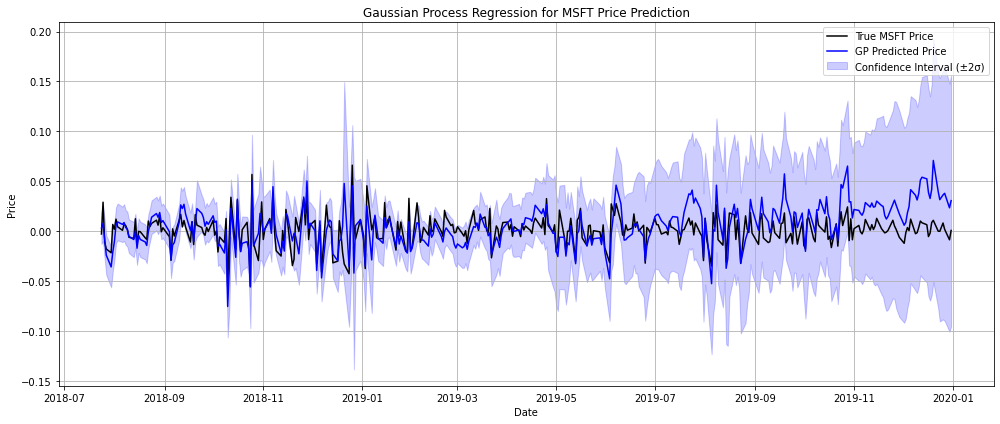

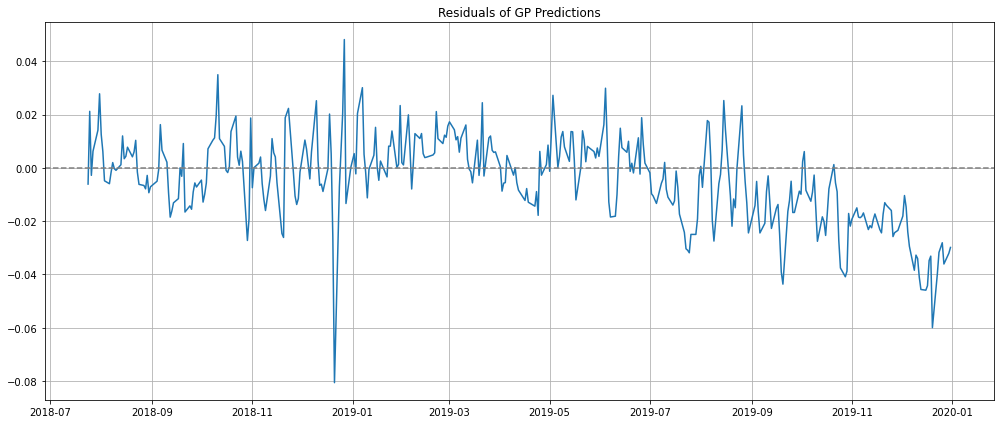

MSE: 0.0002790123410799938
RMSE: 0.01670366250497159
R-squared score -0.2339876508776153
MAE 0.012686725473516233
MSE Train: 4.7349312606732116e-05


In [5]:
# ---------------------- Visualization ----------------------
plt.figure(figsize=(14,6))
plt.plot(y_test.index.to_numpy(), y_test.values, label="True MSFT Price", color='black')
plt.plot(y_test.index.to_numpy(), y_pred, label="GP Predicted Price", color='blue')
plt.fill_between(y_test.index.to_numpy(), y_pred - 2*y_std, y_pred + 2*y_std,
                 color='blue', alpha=0.2, label='Confidence Interval (±2σ)')
plt.title("Gaussian Process Regression for MSFT Price Prediction")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14,6))
plt.plot(y_test.index.to_numpy(), residuals, label="Residuals")
plt.axhline(0, linestyle='--', color='gray')
plt.title("Residuals of GP Predictions")
plt.grid(True)
plt.tight_layout()
plt.show()

#Check accuracy of the results
print("MSE:", mean_squared_error(y_test, y_pred))
print("RMSE:", root_mean_squared_error(y_test, y_pred))
print("R-squared score", r2_score(y_test,y_pred))
print("MAE", mean_absolute_error(y_test,y_pred))

print("MSE Train:", mean_squared_error(y_pred_train, y_train))